In [1]:
# --- Imports ---
import os
import sys
import random
import pickle
import gymnasium as gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# --- GPU Configuration ---
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# --- Add Modules directory to Python path ---
module_path = os.path.abspath(os.path.join('.', 'Modules'))

if module_path not in sys.path:
    sys.path.append(module_path)
    print(f"Added '{module_path}' to sys.path")
else:
    print(f"'{module_path}' already in sys.path")

# --- Import custom modules ---
from env_romo_batch import WorkingMemoryEnv
from actor_critic_song import ActorCriticAgent
from reinforce_song_batch import train_agent
from helper_functions import plot_metrics, plot_performance_matrix, plot_mean_firing_rate_trace, sesgo_contraccion, load_model, save_model 

# --- Set Random Seeds ---
seed_value = 1
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

print("Setup Complete.")

2025-08-29 12:06:55.284329: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756462017.062921  304939 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756462017.554982  304939 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756462022.588517  304939 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756462022.588545  304939 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756462022.588547  304939 computation_placer.cc:177] computation placer alr

Added '/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules' to sys.path
Setup Complete.


In [ ]:
def main():
    # --- Training Configuration ---
    config = {
        "dt": 10,
        "reward_correct": 1.0,
        "reward_incorrect": 0.0,
        "reward_aborted": -1.0,
        "input_noise_sigma": 0.01,
        "reward_fixation": 0.1,
        "reward_decide_fixation": -0.1,
        "duration_params": [1500, 3000, 500, 3000, 500, 1500], 
        "actor_hidden_size": 150,
        "critic_hidden_size": 150,
        "actor_layers": 1,
        "critic_layers": 1,
        "layer_type": "GRU_modified",
        "actor_lr": 1e-4,
        "critic_lr": 1e-4,
        "batch_size": 10,
        "num_episodes": 20000,
        "gamma": 1.0,
        "l2_actor": 1e-4,
        "l2_critic": 1e-4,
        "print_interval": 100,
        "record_history": True
    }

    print("Configuration loaded:")
    for key, value in config.items():
        print(f"  {key}: {value}")

    # --- Configuración del Entorno ---
    print("\nCreating WorkingMemory environment...")
    env = WorkingMemoryEnv(
        dt=config["dt"],
        reward_correct=config["reward_correct"],
        reward_incorrect=config["reward_incorrect"],
        reward_aborted=config["reward_aborted"],
        reward_fixation=config["reward_fixation"],
        reward_decide_fixation=config["reward_decide_fixation"],
        input_noise_sigma=config["input_noise_sigma"],
        duration_params=config["duration_params"]
    )
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.n
    print(f"Observation size: {obs_size}, Action size: {act_size}")

    # --- Configuración del Agente ---
    print("\nInitializing Actor-Critic Agent...")
    agent = ActorCriticAgent(
        obs_size=obs_size,
        act_size=act_size,
        actor_hidden_size=config["actor_hidden_size"],
        critic_hidden_size=config["critic_hidden_size"],
        actor_layers=config["actor_layers"],
        critic_layers=config["critic_layers"],
        actor_lr=config["actor_lr"],
        critic_lr=config["critic_lr"],
        layer_type=config["layer_type"]
    )
    print("Agent Initialized.")

    # --- Entrenamiento ---
    print(f"\nStarting training for {config['num_episodes']} episodes...")
    total_rewards_history, actor_loss_history, critic_loss_history, actor_firing_rates, critic_firing_rates, other_measurements = train_agent(
        env=env,
        agent=agent,
        num_episodes=config["num_episodes"],
        gamma=config["gamma"],
        print_interval=config["print_interval"],
        l2_actor=config["l2_actor"],
        l2_critic=config["l2_critic"],
        batch_size=config["batch_size"],
        record_history=config["record_history"]
    )
    print("\nTraining finished.")

    # --- Guardar checkpoint del modelo ---
    this_stage = 1
    this_ckpt_dir = 'checkpoints/WM+b_F_rnn'
    save_model(agent, this_stage, this_ckpt_dir)

    # --- Save outputs ---
    output_dir  = Path.cwd() / "outputs"
    output_dir.mkdir(parents=True, exist_ok=True)
    output_file = output_dir / "WM+b_F_rnn.pkl"
    with open(output_file, "wb") as f:
        pickle.dump((
            total_rewards_history,
            actor_loss_history,
            critic_loss_history,
            actor_firing_rates,
            critic_firing_rates,
            other_measurements
        ), f)
    print(f"Training history saved to {output_file}")

    # --- Cerrar el Entorno ---
    print("\nClosing the environment...")
    env.close()
    print("Environment closed.")


if __name__ == '__main__':
    main()

Configuration loaded:
  dt: 10
  reward_correct: 1.0
  reward_incorrect: 0.0
  reward_aborted: -1.0
  input_noise_sigma: 0.01
  reward_fixation: 0.1
  reward_decide_fixation: -0.1
  duration_params: [10, 10, 10, 10, 10, 10]
  actor_hidden_size: 150
  critic_hidden_size: 150
  actor_layers: 1
  critic_layers: 1
  layer_type: GRU_modified
  actor_lr: 0.0001
  critic_lr: 0.0001
  batch_size: 10
  num_episodes: 20000
  gamma: 1.0
  l2_actor: 0.0001
  l2_critic: 0.0001
  print_interval: 100
  record_history: True

Creating WorkingMemory environment...
Observation size: 3, Action size: 3

Initializing Actor-Critic Agent...
Agent Initialized.

Starting training for 20000 episodes...


2025-08-28 14:58:21.435737: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Batch 100/2000	Avg Reward: -0.99	Avg Actor Loss: -1.0477	Avg Critic Loss: 0.9050
Batch 200/2000	Avg Reward: -0.97	Avg Actor Loss: -0.9184	Avg Critic Loss: 0.6935
Batch 300/2000	Avg Reward: -0.99	Avg Actor Loss: -0.6863	Avg Critic Loss: 0.3849
Batch 400/2000	Avg Reward: -0.96	Avg Actor Loss: -0.3024	Avg Critic Loss: 0.1337
Batch 500/2000	Avg Reward: -0.99	Avg Actor Loss: -0.2424	Avg Critic Loss: 0.0607
Batch 600/2000	Avg Reward: -0.68	Avg Actor Loss: 0.2145	Avg Critic Loss: 0.6776
Batch 700/2000	Avg Reward: -0.96	Avg Actor Loss: -0.1111	Avg Critic Loss: 0.0552
Batch 800/2000	Avg Reward: -0.92	Avg Actor Loss: -0.0907	Avg Critic Loss: 0.0584
Batch 900/2000	Avg Reward: -0.93	Avg Actor Loss: -0.0516	Avg Critic Loss: 0.0323
Batch 1000/2000	Avg Reward: -0.93	Avg Actor Loss: -0.0777	Avg Critic Loss: 0.0520
Batch 1100/2000	Avg Reward: -0.90	Avg Actor Loss: -0.0712	Avg Critic Loss: 0.0275
Batch 1200/2000	Avg Reward: -0.99	Avg Actor Loss: -0.0292	Avg Critic Loss: 0.0115
Batch 1300/2000	Avg Reward

: 

Configuration loaded:
  dt: 10
  reward_correct: 1.0
  reward_incorrect: 0.0
  reward_aborted: -1.0
  input_noise_sigma: 0.01
  reward_fixation: 0.1
  reward_decide_fixation: -0.1
  duration_params: [10, 10, 10, 10, 10, 10]
  actor_hidden_size: 150
  critic_hidden_size: 150
  actor_layers: 1
  critic_layers: 1
  layer_type: GRU_modified
  actor_lr: 0.0001
  critic_lr: 0.0001
  batch_size: 10
  num_episodes: 20000
  gamma: 1.0
  l2_actor: 0.0001
  l2_critic: 0.0001
  print_interval: 100
  record_history: True

Creating WorkingMemory environment...
Observation size: 3, Action size: 3

Initializing Actor-Critic Agent...


2025-08-29 12:08:58.092083: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/cienciadatosenv/lib/python3.12/site-packages/keras/src/layers/layer.py:396: UserWarning: `build()` was called on layer 'actor_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/cienciadatosenv/lib/python3.12/site-packages/keras/src/layers/layer.py:396: UserWarning: `build()` was called on layer 'critic_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be m

Agent Initialized.
Actor and Critic networks built.
Performing dummy forward to build cells and weights for mask loading...
Loading masks from stage 1...
Masks loaded.
Initializing optimizers with dummy step...
Optimizers initialized.
Restoring from checkpoint: checkpoints/WM+b_F_rnn_1/ckpt-1
Checkpoint restored successfully.

Starting training for 20000 episodes...
Batch 100/2000	Avg Reward: -1.00	Avg Actor Loss: -0.0196	Avg Critic Loss: 0.0032
Batch 200/2000	Avg Reward: -0.72	Avg Actor Loss: 0.1766	Avg Critic Loss: 0.3271
Batch 300/2000	Avg Reward: -0.96	Avg Actor Loss: -0.0280	Avg Critic Loss: 0.0076
Batch 400/2000	Avg Reward: -0.93	Avg Actor Loss: -0.0087	Avg Critic Loss: 0.0082
Batch 500/2000	Avg Reward: -0.96	Avg Actor Loss: -0.0084	Avg Critic Loss: 0.0035
Batch 600/2000	Avg Reward: -0.99	Avg Actor Loss: -0.0056	Avg Critic Loss: 0.0036
Batch 700/2000	Avg Reward: -0.95	Avg Actor Loss: -0.0328	Avg Critic Loss: 0.0421
Batch 800/2000	Avg Reward: -0.99	Avg Actor Loss: -0.0133	Avg Crit

ValueError: x and y must have same first dimension, but have shapes (22000,) and (4000,)

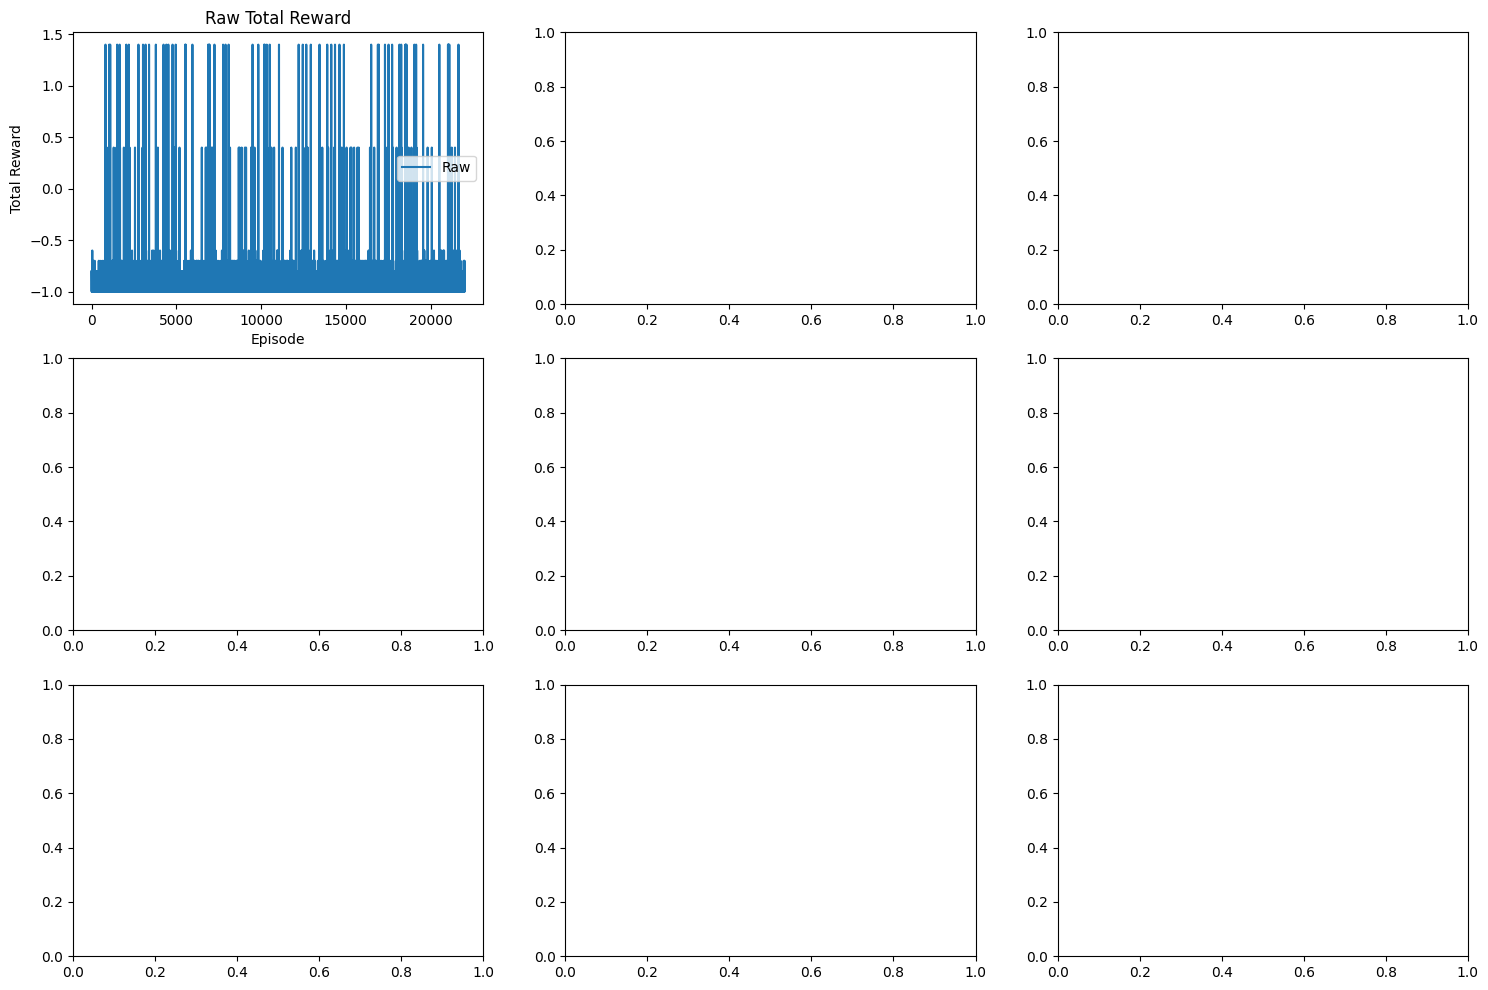

In [2]:
def main():
    # --- Training Configuration ---
    config = {
        "dt": 10,
        "reward_correct": 1.0,
        "reward_incorrect": 0.0,
        "reward_aborted": -1.0,
        "input_noise_sigma": 0.01,
        "reward_fixation": 0.1,
        "reward_decide_fixation": -0.1,
        "duration_params": [10, 10, 10, 10, 10, 10], 
        "actor_hidden_size": 150,
        "critic_hidden_size": 150,
        "actor_layers": 1,
        "critic_layers": 1,
        "layer_type": "GRU_modified",
        "actor_lr": 1e-4,
        "critic_lr": 1e-4,
        "batch_size": 10,
        "num_episodes": 20000,
        "gamma": 1.0,
        "l2_actor": 1e-4,
        "l2_critic": 1e-4,
        "print_interval": 100,
        "record_history": True
    }

    print("Configuration loaded:")
    for key, value in config.items():
        print(f"  {key}: {value}")

    # --- Configuración del Entorno ---
    print("\nCreating WorkingMemory environment...")
    env = WorkingMemoryEnv(
        dt=config["dt"],
        reward_correct=config["reward_correct"],
        reward_incorrect=config["reward_incorrect"],
        reward_aborted=config["reward_aborted"],
        reward_fixation=config["reward_fixation"],
        reward_decide_fixation=config["reward_decide_fixation"],
        input_noise_sigma=config["input_noise_sigma"],
        duration_params=config["duration_params"]
    )
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.n
    print(f"Observation size: {obs_size}, Action size: {act_size}")

    # --- Configuración del Agente ---
    print("\nInitializing Actor-Critic Agent...")
    agent = ActorCriticAgent(
        obs_size=obs_size,
        act_size=act_size,
        actor_hidden_size=config["actor_hidden_size"],
        critic_hidden_size=config["critic_hidden_size"],
        actor_layers=config["actor_layers"],
        critic_layers=config["critic_layers"],
        actor_lr=config["actor_lr"],
        critic_lr=config["critic_lr"],
        layer_type=config["layer_type"]
    )
    print("Agent Initialized.")

    # --- Load checkpoint ---
    this_stage = 2
    this_ckpt_dir = 'checkpoints/WM+b_F_rnn'
    load_model(agent, obs_size, act_size, this_stage, this_ckpt_dir)

    # --- Entrenamiento ---
    print(f"\nStarting training for {config['num_episodes']} episodes...")
    total_rewards_history, actor_loss_history, critic_loss_history, actor_firing_rates, critic_firing_rates, other_measurements = train_agent(
        env=env,
        agent=agent,
        num_episodes=config["num_episodes"],
        gamma=config["gamma"],
        print_interval=config["print_interval"],
        l2_actor=config["l2_actor"],
        l2_critic=config["l2_critic"],
        record_history=config["record_history"]
    )
    print("\nTraining finished.")

    # --- Guardar checkpoint del modelo ---
    this_stage = 2
    this_ckpt_dir = 'checkpoints/WM+b_F_rnn'
    save_model(agent, this_stage, this_ckpt_dir)

    # --- Save outputs ---
    output_dir  = Path.cwd() / "outputs"
    output_dir.mkdir(parents=True, exist_ok=True)
    output_file = output_dir / "WM+b_F_rnn_2.pkl"
    with open(output_file, "wb") as f:
        pickle.dump((
            total_rewards_history,
            actor_loss_history,
            critic_loss_history,
            actor_firing_rates,
            critic_firing_rates,
            other_measurements
        ), f)
    print(f"Training history saved to {output_file}")
        
    # --- Graficar Métricas de Entrenamiento y Rendimiento ---
    print("\nPlotting results...")
    
    plot_metrics(
        total_rewards_history,
        actor_loss_history,
        critic_loss_history,
        window_1=max(20, config["num_episodes"] // 50),
        window_2=max(50, config["num_episodes"] // 10)
    )

    plot_mean_firing_rate_trace(
        actor_firing_rates,
        dt=config['dt'],
        title="Actor Mean Firing Rate Trace"
    )

    # --- Cerrar el Entorno ---
    print("\nClosing the environment...")
    env.close()
    print("Environment closed.")


if __name__ == '__main__':
    main()